In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os 
import sys
import datetime as DT

os.chdir(r'C:\Users\Asus\Documents\Holmusk data\datasciencepositionatholmusk')
bill_amount = pd.read_csv('bill_amount.csv')
bill_id = pd.read_csv('bill_id.csv')
clinical_data = pd.read_csv('clinical_data.csv')
demo = pd.read_csv('demographics.csv')

In [2]:
#convert to lowercase for ease of application
demo.gender = demo.gender.apply(lambda x: x.lower())

In [3]:
demo.race = demo.race.apply(lambda x: x.lower())

In [4]:
demo.resident_status = demo.resident_status.apply(lambda x: x.lower())

In [5]:
demo.gender.value_counts()

female    1396
male      1333
m          170
f          101
Name: gender, dtype: int64

In [6]:
demo.race.value_counts()

chinese    1915
malay       629
indian      195
others      161
india       100
Name: race, dtype: int64

In [7]:
demo.resident_status.value_counts()

singaporean          1782
singapore citizen     610
pr                    465
foreigner             143
Name: resident_status, dtype: int64

In [8]:
demo.gender = demo.gender.apply(lambda x: 'male' if x == 'm' else('female' if x == 'f' else (x)))

In [9]:
demo.race = demo.race.apply(lambda x: 'indian' if x == 'india' else(x))

In [10]:
demo.resident_status = demo.resident_status.apply(lambda x: 'singaporean' if x == 'singapore citizen' else(x))

In [11]:
demo.date_of_birth = demo.date_of_birth.astype('datetime64')

In [12]:
now = pd.to_datetime('today').year
demo['age'] = now - demo.date_of_birth.dt.year

In [13]:
demo = demo.drop('date_of_birth', axis =1)

In [14]:
demo = demo.set_index('patient_id')

In [15]:
clinical_data = clinical_data.sort_values(['id', 'date_of_admission'])

In [16]:
cd_dup = clinical_data[[not i for i in clinical_data.duplicated(subset = ['id'])]]

In [17]:
cd_dup = cd_dup.fillna(value = 0)

In [18]:
cd_dup.medical_history_3 = cd_dup.medical_history_3.apply(lambda x: x if type(x) == int else (1 if x == 'Yes' else (0)))

In [19]:
cd_dup.medical_history_2 = cd_dup.medical_history_2.astype('int64')
cd_dup.medical_history_5 = cd_dup.medical_history_5.astype('int64')

In [20]:
cd_dup.date_of_admission = cd_dup.date_of_admission.astype('datetime64')
cd_dup.date_of_discharge = cd_dup.date_of_discharge.astype('datetime64')

In [21]:
cd_dup['inpatient_D'] = (cd_dup.date_of_discharge - cd_dup.date_of_admission).dt.days

In [22]:
cd_dup['BMI'] = (cd_dup.weight/(cd_dup.height*cd_dup.height) * 10000)

In [23]:
cd_dup = cd_dup.drop(['date_of_discharge', 'weight', 'height'], axis =1)

In [24]:
cd_dup = cd_dup.set_index('id')

In [25]:
joined = cd_dup.merge(demo, left_index = True, right_index = True)

In [26]:
bill_id['patient_id'] = bill_id.patient_id.astype(str)
bill_id.set_index('patient_id').sort_index()

,bill_id,date_of_admission
patient_id,,
00225710a878eff524a1d13be817e8e2,8461069832,2014-04-10
00225710a878eff524a1d13be817e8e2,7746811189,2014-04-10
00225710a878eff524a1d13be817e8e2,4692776325,2014-04-10
00225710a878eff524a1d13be817e8e2,5175703971,2014-04-10
0029d90eb654699c18001c17efb0f129,3604841170,2012-11-07
0029d90eb654699c18001c17efb0f129,5621737529,2012-11-07
0029d90eb654699c18001c17efb0f129,5041212157,2012-11-07
0029d90eb654699c18001c17efb0f129,645202091,2012-11-07
0040333abd68527ecb53e1db9073f52e,167943546,2013-01-19


In [27]:
bill = pd.merge(bill_id, bill_amount, on = 'bill_id')

In [28]:
bill = bill.set_index('patient_id', 'date_of_admission').sort_index()

In [29]:
bill = bill.drop('bill_id', axis =1 )

In [30]:
bg = bill.groupby(['patient_id', 'date_of_admission']).amount.sum()

In [31]:
bg_ri = bg.reset_index()

In [32]:
bg_first = bg_ri[[not i for i in bg_ri.duplicated(subset = 'patient_id')]]

In [33]:
bg_first = bg_first.set_index('patient_id')

In [34]:
merged = joined.merge(bg_first, left_index = True, right_index = True)

In [35]:
merged = merged.drop(['date_of_admission_x', 'date_of_admission_y'], axis = 1)

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


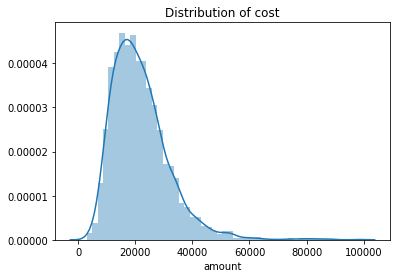

In [36]:
distPlot = sns.distplot(merged['amount'])
plt.title("Distribution of cost")
plt.show()

In [37]:
merged.amount.describe()
#NOTE: Handle outlier cases & assess for need to do log transformation

count     3000.000000
mean     21798.335703
std      10161.000119
min       2946.100354
25%      14665.890997
50%      20101.522184
75%      26733.192619
max      98120.870207
Name: amount, dtype: float64

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


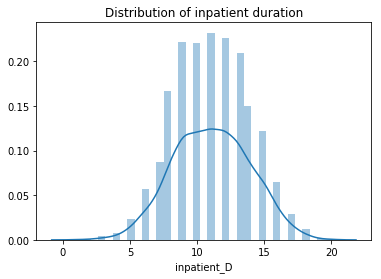

In [38]:
distPlot_inD = sns.distplot(merged['inpatient_D'])
plt.title("Distribution of inpatient duration")
plt.show()

In [39]:
merged.inpatient_D.describe()

count    3000.000000
mean       11.078667
std         2.855497
min         1.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        20.000000
Name: inpatient_D, dtype: float64

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


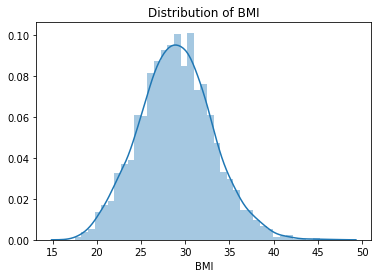

In [40]:
distPlot_bmi = sns.distplot(merged['BMI'])
plt.title("Distribution of BMI")
plt.show()

In [41]:
merged.BMI.describe()

count    3000.000000
mean       28.955222
std         4.144775
min        17.508651
25%        26.161927
50%        28.921908
75%        31.675212
max        46.677349
Name: BMI, dtype: float64

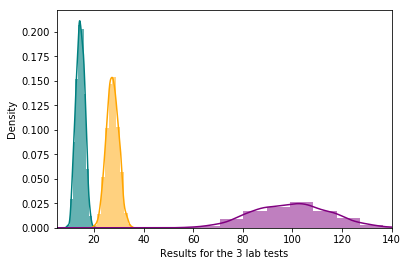

In [47]:
ax = merged['lab_result_1'].hist(density=True, stacked=True, color='teal', alpha=0.6)
merged['lab_result_1'].plot(kind='density', color='teal')
ax = merged['lab_result_2'].hist(density=True, stacked=True, color='orange', alpha=0.5)
merged['lab_result_2'].plot(kind='density', color='orange')
ax = merged['lab_result_3'].hist(density=True, stacked=True, color='purple', alpha=0.5)
merged['lab_result_3'].plot(kind='density', color='purple')
ax.set(xlabel='Results for the 3 lab tests')
plt.xlim(5, 140)
plt.show()
#Most likely the 3 tests are different

In [55]:
#Normalization of numerical columns. Not done on categorical variables for variable inference 
#Choose samples which lie within 3 standard deviations from the mean of normalized variables to preserve sample numbers 
import scipy as sp

numerical_columns = ['amount', 'inpatient_D', 'BMI', 'lab_result_1', 'lab_result_2', 'lab_result_3']
merged_normed = merged[(np.abs(sp.stats.zscore(merged[numerical_columns])) < 3).all(axis=1)]

In [56]:
merged_normed.describe()

,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,...,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,inpatient_D,BMI,age,amount
count,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,...,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000,2307.000000
mean,0.159515,0.281751,0.036411,0.054616,0.057651,0.245774,0.247074,0.501084,0.592111,0.823147,...,0.537061,0.716515,0.513221,14.458994,27.420416,99.628955,11.066753,28.796201,57.047681,20521.425913
std,0.366235,0.449950,0.187351,0.227279,0.233132,0.430638,0.431404,0.500107,0.491549,0.381627,...,0.498733,0.450787,0.499934,1.614473,2.198510,13.581791,2.562296,3.573605,14.552605,7859.621289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,11.000000,22.600000,70.000000,6.000000,20.690444,28.000000,2946.100354
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,13.250000,25.800000,89.000000,9.000000,26.280617,45.000000,14384.507269
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,14.500000,27.400000,100.000000,11.000000,28.800000,55.000000,19578.371459
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,15.700000,29.000000,110.000000,13.000000,31.379989,69.000000,25716.706015
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,17.900000,32.300000,129.000000,16.000000,37.191351,88.000000,42042.921967


C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


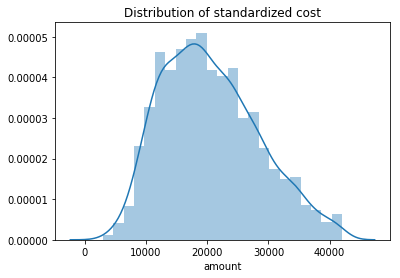

In [57]:
distPlot_cost_normed = sns.distplot(merged_normed['amount'])
plt.title("Distribution of standardized cost")
plt.show()

In [58]:
merged_normed.skew()

medical_history_1     1.860998
medical_history_2     0.970944
medical_history_3     4.953178
medical_history_4     3.922665
medical_history_5     3.798131
medical_history_6     1.181719
medical_history_7     1.173589
preop_medication_1   -0.004337
preop_medication_2   -0.375104
preop_medication_3   -1.694992
preop_medication_4   -0.066834
preop_medication_5   -1.626471
preop_medication_6   -1.097127
symptom_1            -0.480887
symptom_2            -0.668587
symptom_3            -0.148750
symptom_4            -0.961441
symptom_5            -0.052935
lab_result_1         -0.063330
lab_result_2         -0.004155
lab_result_3         -0.005032
inpatient_D           0.030688
BMI                   0.008862
age                   0.302126
amount                0.452053
dtype: float64

In [59]:
Data = merged.reset_index().drop('index', axis =1)

In [60]:
to_encode = ['gender', 'race', 'resident_status']
Data_encoded = pd.get_dummies(Data, columns = to_encode)

In [63]:
from sklearn import linear_model
from sklearn import datasets

X = Data_encoded.drop('amount', axis =1)
X_ = X.as_matrix()
Y = Data_encoded.loc[:, 'amount'].astype('int64')

C:\Users\Asus\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [64]:
X_headers = list(X)

In [83]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
clf = clf.fit(X_, Y)
clf.feature_importances_


array([0.00808754, 0.03276708, 0.00851716, 0.0108599 , 0.00929451,
       0.01529104, 0.02334998, 0.03723962, 0.0295777 , 0.02631034,
       0.0229524 , 0.02002366, 0.0292636 , 0.03236529, 0.03397837,
       0.03502844, 0.02536441, 0.0150884 , 0.06995184, 0.07748226,
       0.0733724 , 0.06964623, 0.07368747, 0.07911353, 0.02489672,
       0.02304489, 0.02160728, 0.01129275, 0.01815354, 0.00843148,
       0.00446999, 0.01419235, 0.01529782])

In [84]:
clf_coefs = list(clf.feature_importances_)
b = list(zip(X_headers,clf_coefs))
clf_fi = pd.DataFrame(data = b, columns = ['Variable', 'Feature Importance']).sort_values('Feature Importance')

In [90]:
clf_fi.tail()

,Variable,Feature Importance
18,lab_result_1,0.069952
20,lab_result_3,0.073372
22,BMI,0.073687
19,lab_result_2,0.077482
23,age,0.079114


Feature ranking:
1. feature 23 (0.079114)
2. feature 19 (0.077482)
3. feature 22 (0.073687)
4. feature 20 (0.073372)
5. feature 18 (0.069952)
6. feature 21 (0.069646)
7. feature 7 (0.037240)
8. feature 15 (0.035028)
9. feature 14 (0.033978)
10. feature 1 (0.032767)
11. feature 13 (0.032365)
12. feature 8 (0.029578)
13. feature 12 (0.029264)
14. feature 9 (0.026310)
15. feature 16 (0.025364)
16. feature 24 (0.024897)
17. feature 6 (0.023350)
18. feature 25 (0.023045)
19. feature 10 (0.022952)
20. feature 26 (0.021607)
21. feature 11 (0.020024)
22. feature 28 (0.018154)
23. feature 32 (0.015298)
24. feature 5 (0.015291)
25. feature 17 (0.015088)
26. feature 31 (0.014192)
27. feature 27 (0.011293)
28. feature 3 (0.010860)
29. feature 4 (0.009295)
30. feature 2 (0.008517)
31. feature 29 (0.008431)
32. feature 0 (0.008088)
33. feature 30 (0.004470)


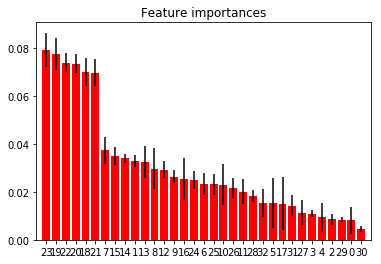

In [93]:
importances = clf.feature_importances_
stdev = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_.shape[1]):
    print("%d. % (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=stdev[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()